In [1]:
import numpy as np                                                                                     
import matplotlib.pyplot as plt                                 
import pandas as pd                                             
import geopandas as gpd                                         
import rasterio
from rasterstats import zonal_stats
from sklearn.preprocessing import Normalizer, StandardScaler
from sklearn.model_selection import KFold, cross_val_score
from sklearn.linear_model import Lasso
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestRegressor
from mlxtend.feature_selection import SequentialFeatureSelector, ExhaustiveFeatureSelector
from sklearn.feature_selection import SelectFromModel
import seaborn as sns
import os

# turns on 'nline plotting', where plot graphics will appear in the notebook below the cell that produced them.
%matplotlib inline              

# Change module setting
pd.options.display.max_colwidth = 80       # Longer text in pd.df

## Data Cleaning and Munging

In [2]:
path= 'F:/Project/2023'
os.chdir(path)

In [3]:
# reads the corn plots
plots= gpd.read_file('2023_plots/plots.shp')


# reads the SAR_optical pairs for each growing period
early_july= rasterio.open('SAR_optical/July/Early_July/16_5_stacked.tif')
late_july= rasterio.open('SAR_optical/July/Late_July/16_5_stacked.tif')
august= rasterio.open('SAR_optical/August/16_5_stacked.tif')
september= rasterio.open('SAR_optical/September/16_5_stacked.tif')

# puts them in a list for looping 
all_4= [early_july.read(), late_july.read(), august.read(), september.read()]

# Transforms pixel coordinates to x,y coordinaetes
affine= late_july.transform

In [4]:
# column names for separating the monthly data into separate dataframes and appending them row-wise
names= ['S1_ELLIP', 'S1_ORIEN', 'S1_LPR', 'S1_I2', 'S1_I1', 'S1_g3', 'S1_g2', 'S1_g1', 'S1_g0', 'S1_DoLP',
            'S1_span', 'S1_entropy_shannon', 'S1_entropy', 'S1_alpha', 'S1_C22', 'S1_C11', 'S2_NDVI', 'S2_NDRE', 'S2_NDWI', 'S2_RECI', 'S2_GCI']

# creates special column names for each month's data
el= [name + '_el' for name in names]
ll= [name + '_ll' for name in names]
au= [name + '_au' for name in names]
se= [name + '_se' for name in names]

# unpacks the names in the above lists into a new list
all_names= [*el , *ll , *au ,*se]


# column names for final training data
new_names= ['Id', 'Name', 'geometry', 'S1_ELLIP', 'S1_ORIEN', 'S1_LPR', 'S1_I2', 'S1_I1', 'S1_g3', 'S1_g2', 'S1_g1', 'S1_g0', 'S1_DoLP',
            'S1_span', 'S1_entropy_shannon', 'S1_entropy', 'S1_alpha', 'S1_C22', 'S1_C11', 'S2_NDVI', 'S2_NDRE', 'S2_NDWI', 'S2_RECI', 'S2_GCI']

In [ ]:
# finds the median of each plot for all the 21 features
median= []
for each in all_4:
    for band in each:
        df_median = pd.DataFrame(zonal_stats(plots, band, affine=affine, stats= 'median'))
        median.append(df_median)

# the result of the above cells is a dataframe for each feature for each month, so this line of code appends them
median_df= pd.concat(median, axis=1)

# renames the columns and splits them based on the growing stage
median_df.columns= all_names
median_el= median_df.filter(like= '_el')
median_ll= median_df.filter(like= '_ll')
median_au= median_df.filter(like= '_au')
median_se= median_df.filter(like= '_se')

# adds median statistics of each growing stage to the plots GeoDataFrame for visualization
median_el_plots = pd.concat([plots, median_el], axis=1)
median_ll_plots = pd.concat([plots, median_ll], axis=1)
median_au_plots = pd.concat([plots, median_au], axis=1)
median_se_plots = pd.concat([plots, median_se], axis=1)

# renames the columns of all dataframes for row-wise concatenation
median_el_plots.columns= new_names
median_ll_plots.columns= new_names
median_au_plots.columns= new_names
median_se_plots.columns= new_names

# row-wise concatenation of data from each growing stage
train_pts= pd.concat([median_el_plots, median_ll_plots, median_au_plots, median_se_plots]).reset_index(drop=True).drop('Id', axis= 1)

# specifies the treatment for each plot
def Treatment_extractor(x):
    return x[0:2]

train_pts['Treatment']= train_pts['Name'].apply(Treatment_extractor)

C:\Users\user\anaconda3\envs\osgeo\lib\site-packages\rasterstats\io.py:328: NodataWarning: Setting nodata to -999; specify nodata explicitly
  warnings.warn(


## Exploratory Data Analysis

Text(0.5, 1.0, 'Late July NDVI')

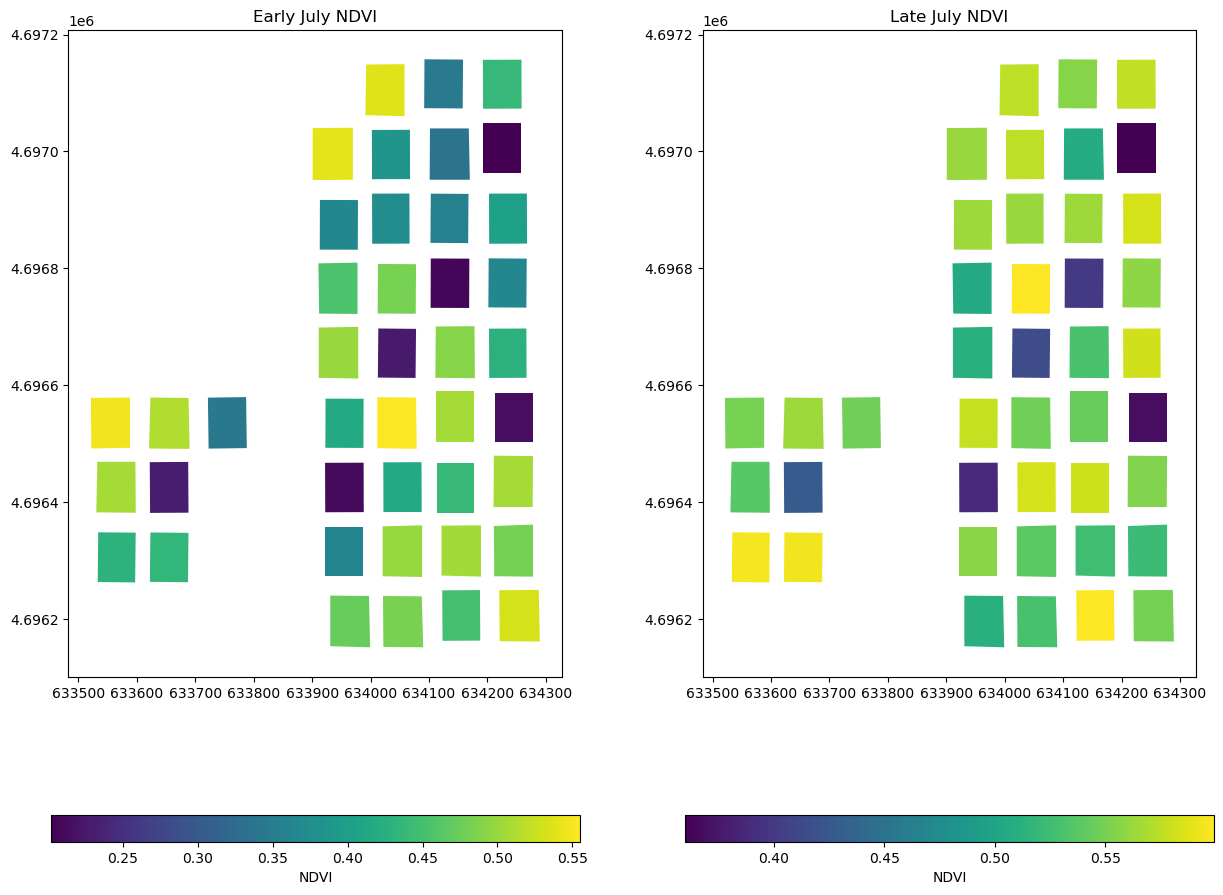

In [6]:
# splits data according to growing stage
e_july= train_pts.iloc[0:42, :]
l_july= train_pts.iloc[42:84, :]
aug= train_pts.iloc[84:126, :]
sep= train_pts.iloc[126:, :]

# plots choropleth maps of NDVI for each plot for each growing stage

# Creates 4 subplots
fig, ax = plt.subplots(nrows= 1, ncols=2, figsize=(15, 12)) 
 
# Access each axes object to plot  data
e_july.plot(column= 'S2_NDVI', ax= ax[0], legend= True, legend_kwds= {'label': 'NDVI', 'orientation': 'horizontal'}).set_title('Early July NDVI')

l_july.plot(column= 'S2_NDVI', ax= ax[1], legend= True, legend_kwds= {'label': 'NDVI', 'orientation': 'horizontal'}).set_title('Late July NDVI')

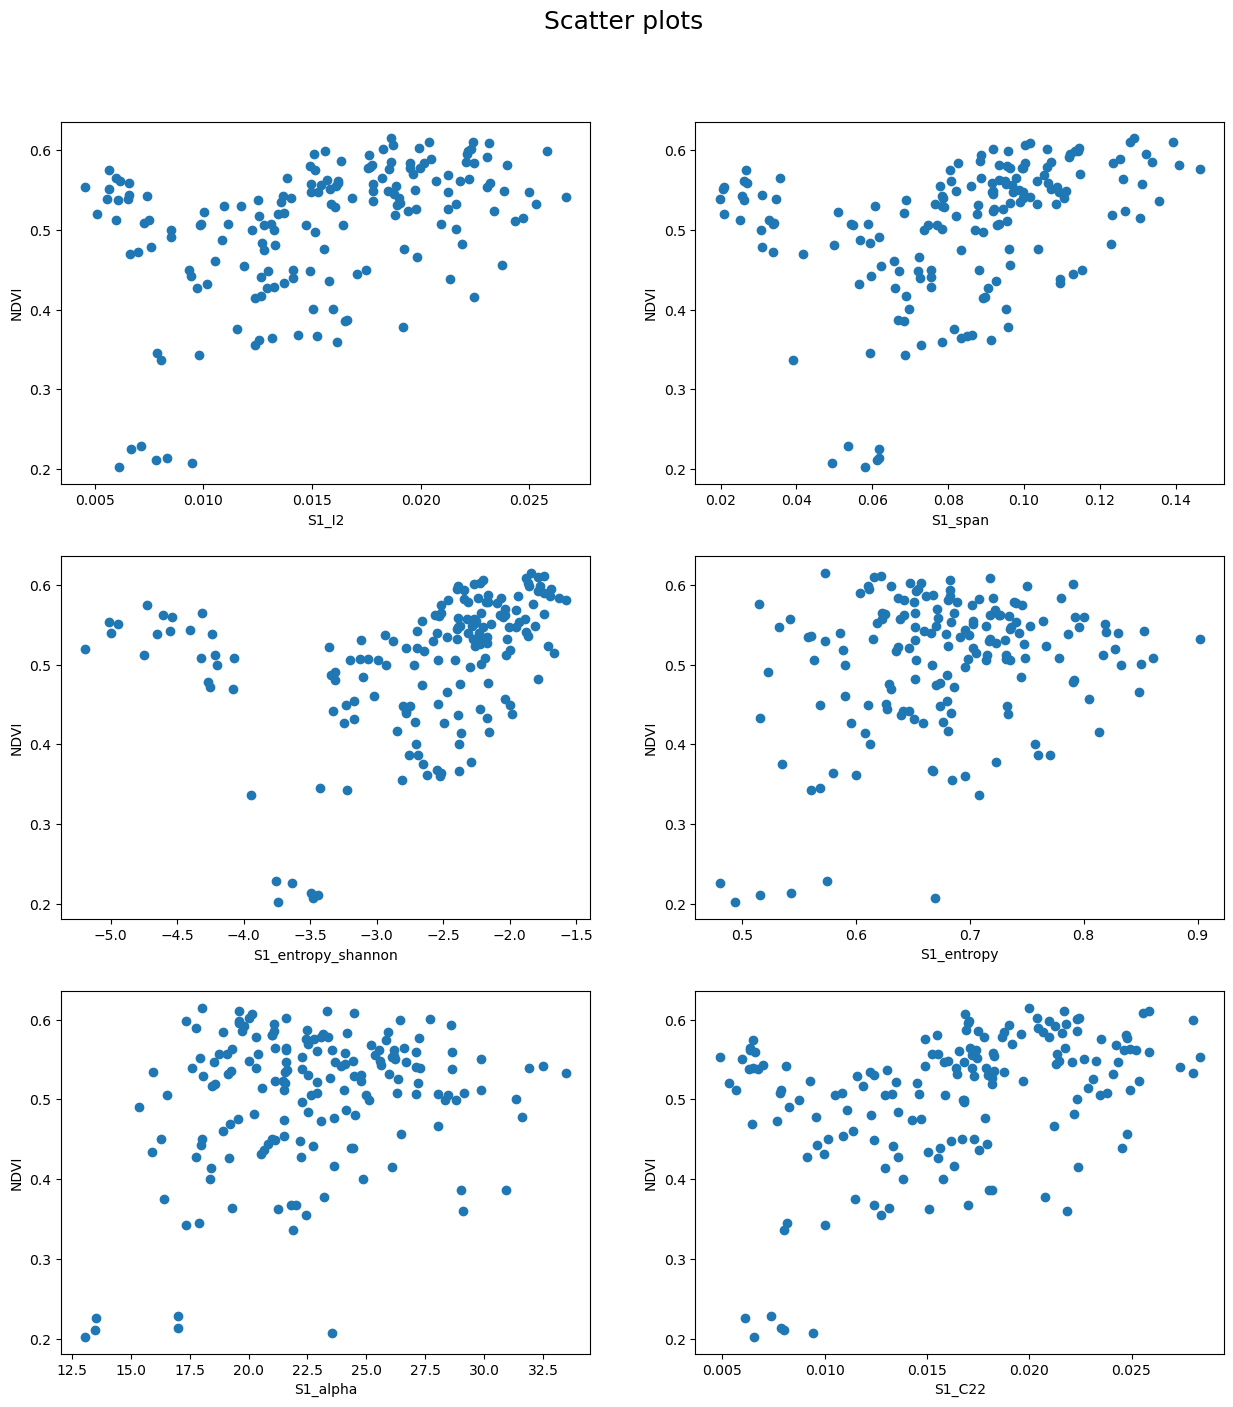

In [7]:
# selects features of interest for plotting
plotting= train_pts.iloc[:, [5, 12, 13, 14, 15, 16]]

# plots scatter plots of the dependent variables(any of the VIs) with some of the independent variable

# defines the subplots
fig, axs= plt.subplots(nrows=3, ncols=2, figsize= (15, 16))
fig.suptitle('Scatter plots', fontsize=18, y=0.95)

# loops through the variables and subplots
for variable, ax in zip(plotting, axs.ravel()):
    ax.scatter(x= plotting[variable], y= train_pts['S2_NDVI'])
    
    ax.set_xlabel(variable)
    ax.set_ylabel('NDVI')

## Modeling

### Feature selection

In [8]:
# partition features and labels
x= train_pts[['S1_ELLIP', 'S1_ORIEN', 'S1_LPR', 'S1_I2', 'S1_I1', 'S1_g3', 'S1_g2', 'S1_g1', 'S1_g0', 'S1_DoLP',
            'S1_span', 'S1_entropy_shannon', 'S1_entropy', 'S1_alpha', 'S1_C22', 'S1_C11']]

#X= StandardScaler().fit_transform(x)

y= train_pts['S2_NDVI']

### Lasso feature importance

In [51]:
#lasso_sel = SelectFromModel(Lasso(alpha=0.001, random_state=10))
#lasso_sel.fit(x,y)

In [52]:
#lasso_sel.get_support()

In [53]:
#lasso_sel.get_feature_names_out()

In [37]:
#x_selected= train_pts[['S1_entropy_shannon', 'S1_entropy', 'S1_I2', 'S1_alpha']]

In [54]:
#scores = cross_val_score(rf, x_selected, y, cv=kf)
#print(scores)
#np.mean(scores)

### Random feature importance

[0.02344029 0.04495336 0.09352893 0.08587313 0.03636039 0.0283182
 0.05055329 0.02704378 0.05251377 0.06708337 0.09706898 0.11874482
 0.0563907  0.11312876 0.07454746 0.03045075]


<function matplotlib.pyplot.show(close=None, block=None)>

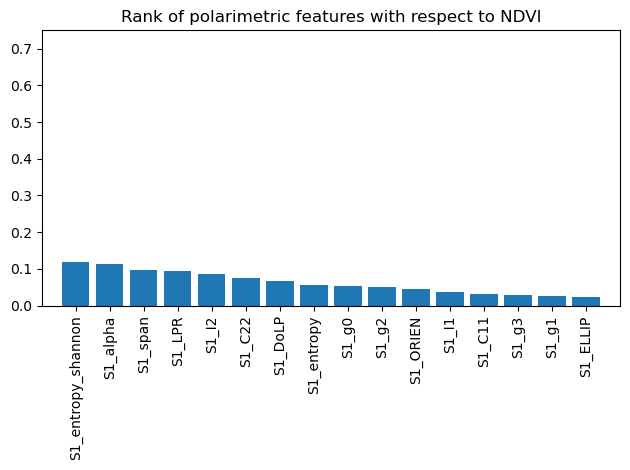

In [9]:
# initiates model
rf= RandomForestRegressor(random_state=42)
rf.fit(x,y)

# # ranks the features using the random forest (impurity) method
rf_importance= rf.feature_importances_
print(rf_importance)

# plots the importance of features in descending order for SAR data
indices= np.argsort(rf_importance)[::-1]

plt.figure()
plt.title('Rank of polarimetric features with respect to NDVI')
plt.bar(range(x.shape[1]), rf_importance[indices])
plt.xticks(range(x.shape[1]), x.iloc[:,:].columns[indices], rotation= 90)
plt.xlim([-1, x.shape[1]])
plt.ylim([0, 0.75])
plt.tight_layout()
plt.show

In [10]:
kf = KFold(n_splits=5, shuffle= True, random_state= 42)

### Sequential Forward Feature Selection

In [11]:
# selects the best features using sequential feature selection
SFS2 = SequentialFeatureSelector(rf, 
           k_features= 'best', 
           forward=True, 
           floating=False, 
           verbose=0,
           scoring='r2',
           cv=kf)


SFS2 = SFS2.fit(x, y)

In [12]:
# prints the selected features from mlxtend
x.columns[list(SFS2.k_feature_idx_)]

Index(['S1_ORIEN', 'S1_g2', 'S1_entropy_shannon'], dtype='object')

In [13]:
# creates a dataframe of r2 scores from different feature combination
metric_dict = SFS2.get_metric_dict(confidence_interval=0.95)
SFS2_df = pd.DataFrame(metric_dict).T
SFS2_df

,feature_idx,cv_scores,avg_score,feature_names,ci_bound,std_dev,std_err
1,"(11,)","[0.3659047693399706, 0.6419839477294123, -0.356547149602106, 0.5094814742264...",0.362983,"(S1_entropy_shannon,)",0.481523,0.374641,0.187321
2,"(1, 11)","[0.3672927569232265, 0.6149649686460308, 0.040500284318768065, 0.57759456790...",0.446154,"(S1_ORIEN, S1_entropy_shannon)",0.287687,0.22383,0.111915
3,"(1, 6, 11)","[0.3830535289701156, 0.5998056802167837, 0.08138564987782504, 0.572538787258...",0.453653,"(S1_ORIEN, S1_g2, S1_entropy_shannon)",0.263836,0.205273,0.102637
4,"(1, 6, 10, 11)","[0.3783841810406816, 0.5910799403241214, 0.10695000243151342, 0.497089638327...",0.438822,"(S1_ORIEN, S1_g2, S1_span, S1_entropy_shannon)",0.239365,0.186234,0.093117
5,"(1, 6, 10, 11, 15)","[0.302509832859838, 0.5756396464621171, 0.07537632341413858, 0.5191885704356...",0.414695,"(S1_ORIEN, S1_g2, S1_span, S1_entropy_shannon, S1_C11)",0.256521,0.199582,0.099791
6,"(1, 3, 6, 10, 11, 15)","[0.20888531227701745, 0.5943792613531471, 0.04462006894586079, 0.51398862576...",0.393192,"(S1_ORIEN, S1_I2, S1_g2, S1_span, S1_entropy_shannon, S1_C11)",0.290268,0.225839,0.112919
7,"(1, 3, 6, 7, 10, 11, 15)","[0.1382370499666833, 0.5555675316533777, 0.10550650473399326, 0.531740590884...",0.389354,"(S1_ORIEN, S1_I2, S1_g2, S1_g1, S1_span, S1_entropy_shannon, S1_C11)",0.283214,0.22035,0.110175
8,"(1, 3, 4, 6, 7, 10, 11, 15)","[0.1426536829548506, 0.5515814918439782, 0.11907583909760555, 0.512334262608...",0.383452,"(S1_ORIEN, S1_I2, S1_I1, S1_g2, S1_g1, S1_span, S1_entropy_shannon, S1_C11)",0.267197,0.207888,0.103944
9,"(1, 3, 4, 6, 7, 10, 11, 14, 15)","[0.05555376091034803, 0.5480544789515087, 0.10889021006813038, 0.52142938032...",0.369755,"(S1_ORIEN, S1_I2, S1_I1, S1_g2, S1_g1, S1_span, S1_entropy_shannon, S1_C22, ...",0.305044,0.237334,0.118667
10,"(1, 3, 4, 6, 7, 8, 10, 11, 14, 15)","[0.058508523784378874, 0.5358944762307282, 0.0949108595729895, 0.51472614269...",0.362012,"(S1_ORIEN, S1_I2, S1_I1, S1_g2, S1_g1, S1_g0, S1_span, S1_entropy_shannon, S...",0.302278,0.235182,0.117591
